# KHANES 대사성 질환 전처리

KNHANES 2023 추출 데이터로부터 생물학적, 심리학적, 사회/행동적 (BPS) 영역을 선별하여 `docs/methods.pdf`의 연구 설계에 맞춘 모델링 준비 완료 데이터셋을 구축합니다.
구체적으로는 비흡연/비음주 성인 중 20~64세를 필터링하고, 이상치를 처리하고, 선형 보간법을 수행한 후, 간단한 탐색적 데이터 분석(EDA) 내용을 포함합니다.

## Google Colab에서 실행하기

Colab에서 실행시 필요함

In [ ]:
# Google Colab 환경 감지 및 설정
import os
import sys

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("🔵 Google Colab 환경에서 실행 중입니다.")
    
    # 필요한 패키지 설치
    import subprocess
    import sys
    packages = ['pandas', 'numpy', 'scipy', 'scikit-learn', 
                'matplotlib', 'seaborn', 'pyarrow', 'missingno']
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q'] + packages)
    
    # 디렉토리 구조 생성
    os.makedirs('data', exist_ok=True)
    os.makedirs('src', exist_ok=True)
    
    # utils.py 파일이 없으면 GitHub에서 다운로드 시도
    if not os.path.exists('src/utils.py'):
        print("📝 src/utils.py 파일을 다운로드합니다...")
        try:
            import urllib.request
            # GitHub raw URL (실제 사용 시 YOUR_USERNAME을 실제 사용자명으로 변경)
            url = 'https://raw.githubusercontent.com/YOUR_USERNAME/aicap-2025-2/main/src/utils.py'
            urllib.request.urlretrieve(url, 'src/utils.py')
            print("✅ src/utils.py 다운로드 완료")
        except Exception as e:
            print(f"⚠️ 자동 다운로드 실패: {e}")
            print("   수동으로 src/utils.py 파일을 생성하거나 GitHub에서 복사하세요.")
    
    # 데이터 파일 업로드 안내
    print("\n📁 데이터 파일 업로드가 필요합니다:")
    print("   1. 다음 셀을 실행하여 khanes-2023.csv 파일을 업로드하세요.")
    print("   2. 또는 Google Drive에 데이터를 저장하고 마운트하세요.")
    
else:
    print("💻 로컬 환경에서 실행 중입니다.")


In [ ]:
# Colab에서만 실행: 데이터 파일 업로드
if IN_COLAB:
    from google.colab import files
    
    print("📤 khanes-2023.csv 파일을 업로드하세요:")
    uploaded = files.upload()
    
    # 업로드된 파일을 data 폴더로 이동
    for filename in uploaded.keys():
        if filename.endswith('.csv'):
            os.rename(filename, f'data/{filename}')
            print(f"✅ {filename} 파일이 data/ 폴더로 이동되었습니다.")
    
    # Google Drive 마운트 옵션 (선택사항)
    print("\n💾 또는 Google Drive를 사용하려면 아래 주석을 해제하세요:")
    print("# from google.colab import drive")
    print("# drive.mount('/content/drive')")
    print("# DATA_PATH = Path('/content/drive/MyDrive/path/to/khanes-2023.csv')")
else:
    print("⏭️ 로컬 환경에서는 이 셀을 건너뜁니다.")


## 전처리 코드

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import (
    load_khanes_data,
    replace_numeric_sentinels,
    cap_iqr_outliers,
    interpolate_numeric_features,
    standardize_features,
    compute_metabolic_flag,
    filter_non_smoking_non_drinking,
)

pd.set_option("display.max_columns", 100)
sns.set_theme(style="whitegrid", context="talk")

DATA_PATH = Path("data/khanes-2023.csv")
OUTPUT_PATH_CSV = Path("data/khanes_preprocessed.csv")

In [ ]:
TARGET_COLS = ["DI1_dg", "DE1_dg", "DI2_dg"]
BIO_COLS = [
    "sex",
    "age",
    "HE_ht",
    "HE_wt",
    "HE_wc",
    "HE_BMI",
    "HE_sbp",
    "HE_dbp",
    "HE_glu",
    "HE_HbA1c",
    "HE_chol",
    "HE_HDL_st2",
    "HE_TG",
    "HE_LDL_drct",
]
PSY_GAD_COLS = [
    "BP_GAD_1",
    "BP_GAD_2",
    "BP_GAD_3",
    "BP_GAD_4",
    "BP_GAD_5",
    "BP_GAD_6",
    "BP_GAD_7",
]
PSY_CORE_COLS = ["mh_stress"]
SOC_BEHAV_COLS = [
    "edu",
    "ho_incm5",
    "marri_1",
    "pa_aerobic",
    "N_EN",
    "N_PROT",
    "N_FAT",
    "N_SFA",
    "N_CHO",
    "N_TDF",
    "N_SUGAR",
    "N_NA",
    "N_K",
    "N_VITC",
    "N_VITD",
]
LIFESTYLE_COLS = ["sm_presnt", "BD1", "dr_month"]
ID_COLS = ["ID", "ID_fam", "year"]

USECOLS = sorted(
    set(
        ID_COLS
        + TARGET_COLS
        + BIO_COLS
        + PSY_GAD_COLS
        + PSY_CORE_COLS
        + SOC_BEHAV_COLS
        + LIFESTYLE_COLS
    )
)
print(f"Total columns pulled: {len(USECOLS)}")

Total columns pulled: 46


In [ ]:
raw_df = load_khanes_data(DATA_PATH, usecols=USECOLS, low_memory=False)
print(f"Raw shape: {raw_df.shape}")
raw_df.head()

Raw shape: (6929, 46)


,ID,ID_fam,year,sex,age,ho_incm5,edu,marri_1,DI1_dg,DI2_dg,DE1_dg,BD1,dr_month,BP_GAD_1,BP_GAD_2,BP_GAD_3,BP_GAD_4,BP_GAD_5,BP_GAD_6,BP_GAD_7,mh_stress,sm_presnt,pa_aerobic,HE_sbp,HE_dbp,HE_ht,HE_wt,HE_wc,HE_BMI,HE_glu,HE_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,N_EN,N_PROT,N_FAT,N_SFA,N_CHO,N_TDF,N_SUGAR,N_NA,N_K,N_VITD,N_VITC
0,YA84208301,YA842083,2023.0,1.0,75.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.0,88.0,159.8,58.9,90.2,23.065440,125.0,6.0,166.0,38.0,162.0,101.0,624.642550,18.927046,25.627933,9.216467,81.943318,20.930879,48.082091,501.630439,1297.868017,0.587070,29.390490
1,YA84208302,YA842083,2023.0,2.0,70.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,131.0,84.0,151.2,41.8,65.2,18.284063,105.0,5.5,218.0,67.0,74.0,139.0,922.289958,33.330471,50.315861,18.138261,77.965687,5.314416,47.560904,1923.830383,994.107616,1.174140,15.650710
2,YA84212402,YA842124,2023.0,2.0,42.0,3.0,3.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,60.5,156.7,53.5,71.8,21.787921,102.0,5.3,196.0,87.0,43.0,105.0,3521.884974,190.252617,122.484520,23.925787,414.337910,25.209885,83.408735,5362.983379,4533.091266,0.108327,35.242941
3,YA84212404,YA842124,2023.0,2.0,9.0,3.0,1.0,2.0,8.0,8.0,8.0,8.0,NaN,8.0,8.0,8.0,8.0,8.0,8.0,8.0,NaN,NaN,NaN,139.0,62.0,142.0,35.8,59.6,17.754414,NaN,NaN,NaN,NaN,NaN,NaN,3476.032477,153.000712,100.613773,24.660589,467.455665,18.917919,46.068955,2849.206185,2507.678074,1.333000,69.595766
4,YA84242702,YA842427,2023.0,1.0,43.0,5.0,4.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,131.0,95.0,185.0,79.8,86.9,23.316289,101.0,5.5,176.0,40.0,145.0,116.0,2624.110312,86.885509,50.167467,18.278104,447.247774,29.890427,108.118573,6600.858453,3505.069908,1.680265,65.171145


In [ ]:
df = raw_df.copy()
numeric_cols = [col for col in df.columns if col not in ID_COLS]
df = replace_numeric_sentinels(df, columns=numeric_cols)
filtered_df = filter_non_smoking_non_drinking(df)
print(f"Filtered shape (non-smoking/non-drinking 20-64): {filtered_df.shape}")
filtered_df.head()

Filtered shape (non-smoking/non-drinking 20-64): (1256, 46)


,ID,ID_fam,year,sex,age,ho_incm5,edu,marri_1,DI1_dg,DI2_dg,DE1_dg,BD1,dr_month,BP_GAD_1,BP_GAD_2,BP_GAD_3,BP_GAD_4,BP_GAD_5,BP_GAD_6,BP_GAD_7,mh_stress,sm_presnt,pa_aerobic,HE_sbp,HE_dbp,HE_ht,HE_wt,HE_wc,HE_BMI,HE_glu,HE_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,N_EN,N_PROT,N_FAT,N_SFA,N_CHO,N_TDF,N_SUGAR,N_NA,N_K,N_VITD,N_VITC
7,YA84370201,YA843702,2023.0,1.0,53.0,5.0,4.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,109.0,76.0,NaN,NaN,NaN,NaN,95.0,5.3,192.0,NaN,72.0,106.0,2405.776439,97.511292,55.497694,22.160241,388.467076,60.499458,146.041868,3374.435933,5655.370734,4.039241,90.744088
9,YA84382302,YA843823,2023.0,2.0,43.0,3.0,4.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,59.5,156.9,49.7,66.2,20.188800,96.0,5.5,190.0,80.0,61.0,NaN,1924.311916,55.431855,76.508852,21.942785,253.587140,29.537819,98.041469,2621.751413,3843.337045,4.136929,168.705572
15,YA84384304,YA843843,2023.0,1.0,50.0,3.0,3.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,113.5,68.5,165.4,72.9,93.4,26.647503,106.0,5.6,167.0,46.0,52.0,116.0,4336.591553,92.874922,38.042058,14.440066,906.247675,18.036110,24.466859,5718.416427,1477.519639,0.759465,48.541028
26,YA71262901,YA712629,2023.0,1.0,37.0,5.0,4.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,104.5,67.5,173.3,58.1,72.0,19.345458,82.0,5.1,141.0,59.0,71.0,76.0,1605.939678,76.829503,43.108039,15.374128,229.871935,22.858820,85.433022,3810.272260,2979.960745,3.470104,134.800531
29,YA71275103,YA712751,2023.0,2.0,27.0,2.0,4.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.0,68.0,166.3,54.4,73.1,19.670455,87.0,5.1,128.0,53.0,40.0,69.0,1837.870150,41.783098,48.186810,21.028157,302.993834,16.935230,24.218316,2507.863983,1627.709800,0.524507,15.246734


In [ ]:
filtered_df["gad_score"] = filtered_df[PSY_GAD_COLS].sum(axis=1, min_count=1)
feature_cols = BIO_COLS + PSY_CORE_COLS + ["gad_score"] + SOC_BEHAV_COLS
numeric_features = [
    col for col in feature_cols if pd.api.types.is_numeric_dtype(filtered_df[col])
]

filtered_df = cap_iqr_outliers(filtered_df, numeric_features)
filtered_df = interpolate_numeric_features(filtered_df, numeric_features, order_col="age")
filtered_df, scaler_stats = standardize_features(filtered_df, numeric_features)
filtered_df["metabolic_flag"] = compute_metabolic_flag(filtered_df, TARGET_COLS)

preprocessed_df = (
    filtered_df[ID_COLS + feature_cols + TARGET_COLS + ["metabolic_flag"]]
    .dropna(subset=["metabolic_flag"])
)

preprocessed_df.to_csv(OUTPUT_PATH_CSV, index=False, encoding='utf-8-sig')
print(f"Preprocessed rows: {len(preprocessed_df)}")
print(f"Saved to {OUTPUT_PATH_CSV}")

Preprocessed rows: 1256 | saved to data/khanes_preprocessed.parquet


In [ ]:
preprocessed_df.head()

,ID,ID_fam,year,sex,age,HE_ht,HE_wt,HE_wc,HE_BMI,HE_sbp,HE_dbp,HE_glu,HE_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,mh_stress,gad_score,edu,ho_incm5,marri_1,pa_aerobic,N_EN,N_PROT,N_FAT,N_SFA,N_CHO,N_TDF,N_SUGAR,N_NA,N_K,N_VITC,N_VITD,DI1_dg,DE1_dg,DI2_dg,metabolic_flag
7,YA84370201,YA843702,2023.0,-1.664864,0.475566,-0.279755,-0.560473,-0.733159,-0.525054,-0.396032,0.404565,-0.011337,-0.326879,0.054565,1.539728,-0.708910,-0.375474,-0.603105,0.801231,0.780858,1.178384,-0.528226,0.010497,1.115875,1.206839,0.297788,0.795468,1.452600,2.563099,2.399960,0.343015,2.549438,0.422682,0.915824,0.0,0.0,0.0,0
9,YA84382302,YA843823,2023.0,0.600650,-0.331938,-0.737796,-1.069795,-1.358976,-0.905512,-0.729856,-1.441158,0.078217,0.211384,0.001935,1.493776,-0.931541,0.957719,1.658087,0.000478,0.780858,-0.448045,-0.528226,-1.003698,0.354492,-0.341540,1.086412,0.771821,0.049584,0.475733,1.061173,-0.179272,1.022667,1.853464,0.963768,0.0,0.0,0.0,0
15,YA84384304,YA843843,2023.0,-1.664864,0.233315,0.328876,0.776500,1.072767,0.737328,-0.062208,-0.434400,0.973759,0.480516,-0.603300,-0.849772,-1.113693,-0.085649,1.658087,0.000478,-0.614742,-0.448045,-0.528226,-1.003698,2.460750,1.036237,-0.357386,-0.044063,2.500936,-0.511190,-0.990907,1.969503,-1.015920,-0.351847,-0.693858,1.0,1.0,1.0,1
26,YA71262901,YA712629,2023.0,-1.664864,-0.816440,1.320252,-0.401309,-0.840442,-1.120025,-0.729856,-0.546262,-1.175541,-0.865143,-1.287479,0.046290,-0.729149,-1.244948,-0.603105,-0.399898,0.780858,1.178384,-0.528226,1.024692,-0.148978,0.445820,-0.167241,0.057512,-0.197101,-0.097369,0.709509,0.645442,0.278709,1.231225,0.636497,0.0,0.0,0.0,0
29,YA71275103,YA712751,2023.0,0.600650,-1.623944,0.441817,-0.695762,-0.742100,-1.037358,-0.470215,-0.490331,-0.727770,-0.865143,-1.629568,-0.367277,-1.356563,-1.447825,-0.603105,-0.399898,0.780858,-1.261259,1.893130,-1.003698,0.217794,-0.843767,0.023384,0.672359,0.563510,-0.605653,-0.997839,-0.258299,-0.886504,-0.962878,-0.809173,0.0,0.0,0.0,0


In [ ]:
flag_counts = preprocessed_df["metabolic_flag"].value_counts().rename("count")
flag_share = (flag_counts / len(preprocessed_df)).rename("ratio")
pd.concat([flag_counts, flag_share], axis=1)

,count,ratio
metabolic_flag,,
0,894,0.711783
1,362,0.288217


In [ ]:
eda_summary = preprocessed_df.groupby("metabolic_flag")[
    ["HE_BMI", "HE_sbp", "HE_glu", "HE_chol", "gad_score", "N_EN", "N_NA"]
].agg(["mean", "std", "median"])
eda_summary

HE_BMI                        HE_sbp                      \
                    mean       std    median      mean       std    median   
metabolic_flag                                                               
0              -0.127638  0.983494 -0.288657 -0.190735  0.954340 -0.321849   
1               0.315216  0.972907  0.215638  0.471043  0.955871  0.512711   

                  HE_glu                       HE_chol                      \
                    mean       std    median      mean       std    median   
metabolic_flag                                                               
0              -0.236725  0.845327 -0.332239  0.183455  0.896367  0.159823   
1               0.584619  1.109089  0.436434 -0.453063  1.096587 -0.563828   

               gad_score                          N_EN                      \
                    mean       std    median      mean       std    median   
metabolic_flag                                                               
0               0.042800  0.994781 -0.399898  0.013063  1.013068 -0.126751   
1              -0.105699  1.007748 -0.800275 -0.032261  0.969019 -0.171597   

                    N_NA                      
                    mean       std    median  
metabolic_flag                                
0              -0.014657  1.001967 -0.166436  
1               0.036197  0.996972 -0.129464

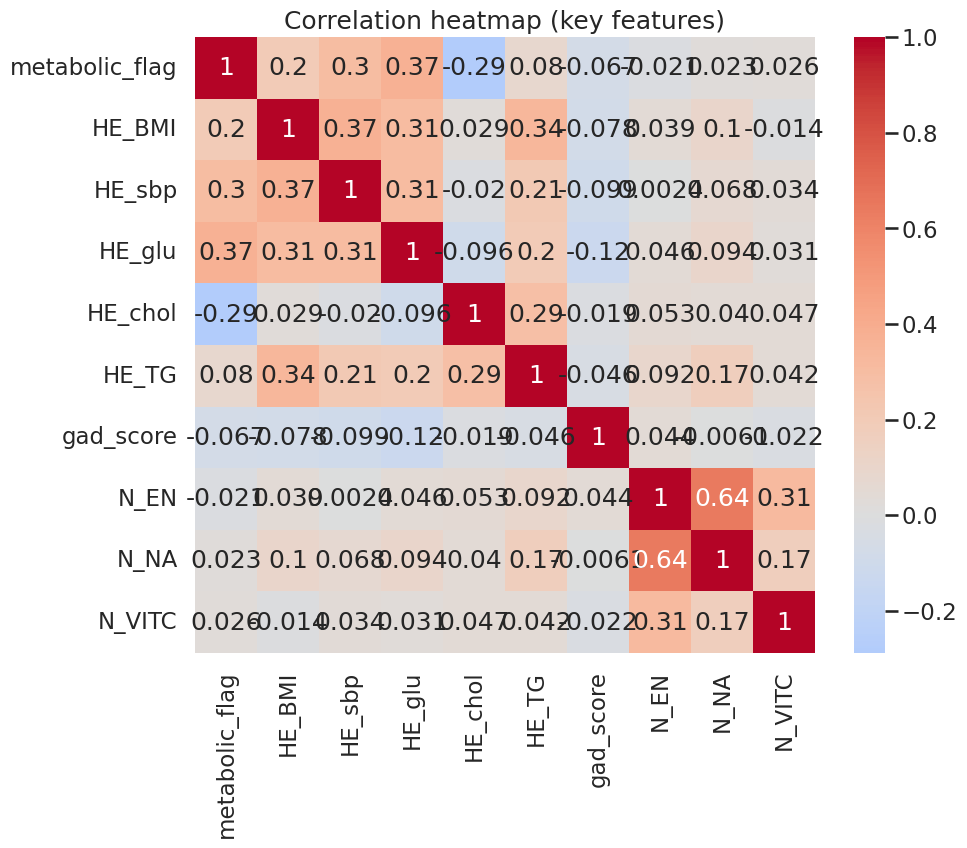

In [ ]:
corr_cols = [
    "metabolic_flag",
    "HE_BMI",
    "HE_sbp",
    "HE_glu",
    "HE_chol",
    "HE_TG",
    "gad_score",
    "N_EN",
    "N_NA",
    "N_VITC",
]
corr_matrix = preprocessed_df[corr_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, center=0)
plt.title("Correlation heatmap (key features)")
plt.show()

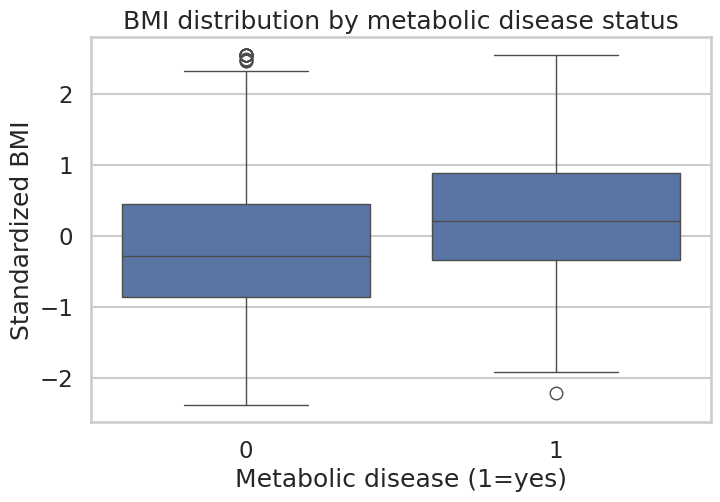

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=preprocessed_df, x="metabolic_flag", y="HE_BMI")
plt.xlabel("Metabolic disease (1=yes)")
plt.ylabel("Standardized BMI")
plt.title("BMI distribution by metabolic disease status")
plt.show()

In [ ]:
pd.DataFrame.from_dict(scaler_stats, orient="index").head()

,mean,std
sex,1.734873,0.441401
age,47.110669,12.383843
HE_ht,162.779284,7.968716
HE_wt,63.142735,12.565705
HE_wc,81.400677,11.185393
